In [8]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

## データセットの準備

In [9]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2020-10-06 06:14:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.0MB/s    in 5.1s    

2020-10-06 06:15:04 (15.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]


^C
Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include 

In [69]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [12]:
print("x : {}".format(x_train[0]))

x : This movie seems to send the wrong message. There can be morality without using Christ. Poeple of other religions, I believe, can get into heaven. I am a Catholic who goes to church every week, but I do not agree with such Christian arrogance. This is the worst time travel movie I have ever seen and I've seen Timeline.


In [13]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [15]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


# BoW

## 【問題1】BoWのスクラッチ実装
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

In [16]:
texts = ["This movie is SOOOO funny!!!",
     "What a movie! I never",
      "best movie ever!!!!! this movie"]

まずはScikit-learnの答えを見てみる

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vc = CountVectorizer()
bow = (vc.fit_transform(texts)).toarray()

df = pd.DataFrame(bow, columns=vc.get_feature_names())
df

,best,ever,funny,is,movie,never,soooo,this,what
0,0,0,1,1,1,0,1,1,0
1,0,0,0,0,1,1,0,0,1
2,1,1,0,0,2,0,0,1,0


### スクラッチ実装

```python
alpha_text = "This movie is SOOOO funny!!!"
alpha_pattern = "\w+"  # \W is also an inverse, which means anything besides alphabet.
alpha_regex = re.compile(alpha_pattern)

all_alpha_matches = alpha_regex.findall(alpha_text)
print(all_alpha_matches)
```

In [18]:
s = "This movie is SOOOO funny!!!"

def sentence_split(text):
  #小文字処理
  text = text.lower()
  #クリーニング
  regex = re.compile("\w+")
  text = regex.findall(text)
  #text = re.sub(r'!', "", text)
  #text = text.split(" ")
  return text

sentence_split(s)

['this', 'movie', 'is', 'soooo', 'funny']

In [19]:
text = "This movie is SOOOO funny!!!"

def n_gram(text, n):
  text = sentence_split(text)
  split_words = [text[i:i+n] for i in range(len(text)-n+1)]
  return [" ".join(words) for words in split_words]

print(n_gram(text, 2))
print(n_gram(text, 3))

['this movie', 'movie is', 'is soooo', 'soooo funny']
['this movie is', 'movie is soooo', 'is soooo funny']


In [20]:
def bag_of_word(texts, n):
  split_words_list = list(map(lambda x: n_gram(x, n), texts))
  bow = []
  for split_words in split_words_list:
    counter = Counter(split_words)
    bow.append(counter)

  df = pd.DataFrame(bow)
  df = df.fillna(0).astype(int)
  return df

display("Bow n_gram is 1",bag_of_word(texts, 1))
display("Bow n_gram is 2",bag_of_word(texts, 2))

'Bow n_gram is 1'

,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


'Bow n_gram is 2'

,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


# TF-IDF

## 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。

ストップワード

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

登場回数の少ないトークンの除外

In [22]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


In [23]:
vc = CountVectorizer(token_pattern=r'\b\w+\b', stop_words=stop_words, max_features=5000)
x_train_bow = vc.fit_transform(x_train).toarray()
df = pd.DataFrame(x_train_bow, columns=vc.get_feature_names())
df.head()

,0,00,000,1,10,100,11,12,13,13th,14,15,16,17,18,1930,1930s,1933,1940,1950,1950s,1960,1960s,1968,1970,1970s,1971,1972,1973,1980,1980s,1983,1984,1987,1990,1993,1995,1996,1997,1999,...,worthwhile,worthy,would,wound,wounded,wow,wrap,wrapped,wreck,wrestling,write,writer,writers,writes,writing,written,wrong,wrote,wwii,x,ya,yard,yeah,year,years,yelling,yellow,yes,yesterday,yet,york,young,younger,youth,z,zero,zizek,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### IMDB映画レビューデータセットのTF=IDF値計算

In [24]:
vec_tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)
x_train_tfidf = vec_tfidf.fit_transform(x_train).toarray()
df = pd.DataFrame(x_train_tfidf, columns=vec_tfidf.get_feature_names())
df.head()

,00,000,10,100,11,12,13,13th,14,15,16,17,18,1930,1930s,1933,1940,1950,1950s,1960,1960s,1968,1970,1970s,1971,1972,1973,1980,1980s,1983,1984,1987,1990,1993,1995,1996,1997,1999,1st,20,...,worthless,worthwhile,worthy,would,wound,wounded,wow,wrap,wrapped,wreck,wrestling,wretched,write,writer,writers,writes,writing,written,wrong,wrote,wwii,ya,yard,yeah,year,years,yelling,yellow,yes,yesterday,yet,york,young,younger,youth,zero,zizek,zombie,zombies,zone
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167188,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.091638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.039881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070496,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。

ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

### まずはベースラインモデル

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
                     ("bow", CountVectorizer()),
                     ("tfidf", TfidfTransformer()),
                     ("classifier", RandomForestClassifier())
])

pipeline.fit(x_train, y_train)
pred = pipeline.predict(x_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.82      0.85      0.84     12500
           1       0.85      0.81      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## 最大の語彙数の数による正答率の変化を観察

In [26]:
from tqdm import tqdm
max_features_pattern = [1000,2000,3000,4000,5000]

for max_features in tqdm(max_features_pattern):
  pipeline = Pipeline([
                      ("bow", CountVectorizer(max_features=max_features)),
                      ("tfidf", TfidfTransformer()),
                      ("classifier", RandomForestClassifier())
  ])

  pipeline.fit(x_train, y_train)
  y_pred = pipeline.predict(x_test)
  print(f"max_features_pattern is {max_features} \n", classification_report(y_test, y_pred))

 20%|██        | 1/5 [01:27<05:51, 87.78s/it]

max_features_pattern is 1000 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



 40%|████      | 2/5 [02:56<04:23, 88.00s/it]

max_features_pattern is 2000 
               precision    recall  f1-score   support

           0       0.82      0.85      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



 60%|██████    | 3/5 [04:09<02:47, 83.61s/it]

max_features_pattern is 3000 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



 80%|████████  | 4/5 [05:20<01:19, 79.83s/it]

max_features_pattern is 4000 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



100%|██████████| 5/5 [06:30<00:00, 78.15s/it]

max_features_pattern is 5000 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### ストップワードを入れることによる正答率の変化を観察

In [27]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

pipeline = Pipeline([
                    ("bow", CountVectorizer(stop_words=stop_words)),
                    ("tfidf", TfidfTransformer()),
                    ("classifier", RandomForestClassifier())
])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



ストップワードを指定することで1～２％の正答率の改善できた

語彙数の変化による正答率の推移を観察

In [28]:
n_gram_pattern = [(1,1), (1,2), (2,2)]

for ngram_range in n_gram_pattern:
  pipeline = Pipeline([
                      ("bow", CountVectorizer(ngram_range=ngram_range)),
                      ("tfidf", TfidfTransformer()),
                      ("classifier", RandomForestClassifier())
  ])

  pipeline.fit(x_train, y_train)
  y_pred = pipeline.predict(x_test)
  print(f"n_gram_pattern is {ngram_range} \n", classification_report(y_test, y_pred))

n_gram_pattern is (1, 1) 
               precision    recall  f1-score   support

           0       0.82      0.85      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

n_gram_pattern is (1, 2) 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85     12500
           1       0.86      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

n_gram_pattern is (2, 2) 
               precision    recall  f1-score   support

           0       0.81      0.86      0.83     12500
           1       0.85      0.80      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83    

ngramが1・2の混在パターンが精度が高くなった

##【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

> This movie is SOOOO funny!!!  
> What a movie! I never  
> best movie ever!!!!! this movie


In [29]:
texts = ["This movie is SOOOO funny!!!",
         "What a movie! I never",
         "best movie ever!!!!! this movie"]

### まずはscikit-learnのtf-idf値をみてみる

In [30]:
vec_tfidf = TfidfVectorizer(stop_words=stop_words, norm=None)
texts_tfidf = vec_tfidf.fit_transform(texts).toarray()
pd.DataFrame(texts_tfidf, columns=vec_tfidf.get_feature_names())

,best,ever,funny,movie,never,soooo
0,0.000000,0.000000,1.693147,1.0,0.000000,1.693147
1,0.000000,0.000000,0.000000,1.0,1.693147,0.000000
2,1.693147,1.693147,0.000000,2.0,0.000000,0.000000


スクラッチ実装（標準式）

In [31]:
countvectrizor = CountVectorizer(stop_words=stop_words)
bow = countvectrizor.fit_transform(texts).toarray()

#tf値の計算
tf  = bow / bow.sum()
print("tf")
display(pd.DataFrame(tf, columns=countvectrizor.get_feature_names()))

#idf値の計算
dft = np.where(bow > 0, True, False).sum(axis=0)
idf = np.log((1 + len(bow)) / (1 + dft)) + 1
print("idf")
display(pd.DataFrame(idf, index=countvectrizor.get_feature_names()).T)
tfidf = tf * idf

print("tf-idf")
pd.DataFrame(tfidf, columns=countvectrizor.get_feature_names())

tf


,best,ever,funny,movie,never,soooo
0,0.000000,0.000000,0.111111,0.111111,0.000000,0.111111
1,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000
2,0.111111,0.111111,0.000000,0.222222,0.000000,0.000000


idf


,best,ever,funny,movie,never,soooo
0,1.693147,1.693147,1.693147,1.0,1.693147,1.693147


tf-idf


,best,ever,funny,movie,never,soooo
0,0.000000,0.000000,0.188127,0.111111,0.000000,0.188127
1,0.000000,0.000000,0.000000,0.111111,0.188127,0.000000
2,0.188127,0.188127,0.000000,0.222222,0.000000,0.000000


In [32]:
np.log((1 + len(bow)) / (1 + dft))

array([0.69314718, 0.69314718, 0.69314718, 0.        , 0.69314718,
       0.69314718])

# Word2Vec

In [33]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.02067613 -0.03452464 -0.01404276  0.02663649 -0.03278029 -0.01535079
  0.00691145  0.00305187 -0.01994236 -0.01413526]
movieのベクトル : 
[-0.00301446 -0.02996304  0.00161175  0.01986781 -0.04786161 -0.04595343
  0.00058435  0.01721146 -0.00232886 -0.04598879]
isのベクトル : 
[-0.0431642   0.04439614 -0.00239189 -0.01082986  0.00708372 -0.00683127
  0.03067909 -0.04040093 -0.00624992 -0.01792545]
veryのベクトル : 
[-0.03872301  0.01921992  0.02845171  0.04514079  0.00982792  0.0159159
  0.00495082  0.01704616  0.04060599  0.00322661]
goodのベクトル : 
[-0.01352904  0.00872707 -0.04415921  0.04474365  0.0473317  -0.03235608
 -0.00486674 -0.04376635  0.01945805  0.02231294]
filmのベクトル : 
[-0.04358     0.03005598 -0.0350576  -0.03599809  0.01206571 -0.03455845
 -0.01364143 -0.02563661  0.03180335 -0.02370233]
aのベクトル : 
[ 0.01395189 -0.02174572 -0.03811771 -0.03438174 -0.03022726  0.01359637
 -0.0146443   0.04415562

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [34]:
#単語のベクトル空間上の距離
model.wv.most_similar(positive="good", topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('film', 0.38813695311546326),
 ('is', 0.26457157731056213),
 ('bad', 0.19759276509284973)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


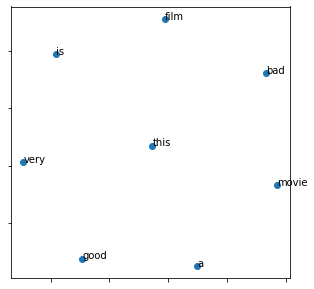

In [35]:
#可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。  
また、単語（トークン）はリストで分割してください。

In [36]:
x_train_original = x_train.copy()
x_test_original  = x_test.copy()

In [140]:
x_train = x_train_original.copy()
x_test = x_test_original.copy()

In [59]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [158]:
#コーパスの前処理
def clean_text(text):
  text = re.sub(r"<.*?>", "", text)
  text = re.sub(r"[^\w\s]", "", text, re.UNICODE)
  text = re.sub(r"https?://\S+|www\.\S+", "", text)
  text = text.lower()
  text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
  text = [lemmatizer.lemmatize(token, "v") for token in text]
  text = [re.sub(r"[^\w\s]", "", word) for word in text if not word in stop_words]

  return text

In [159]:
x_train = list(map(clean_text, x_train))
x_test  = list(map(clean_text, x_test))

In [166]:
len(x_train)

24750

## 【問題6】Word2Vecの学習
Word2Vecの学習を行なってください。

In [165]:
from gensim.models import Word2Vec

model = Word2Vec(min_count=3 ,size=256, window=5, workers=4)
model.build_vocab(x_train)
model.train(x_train, total_examples=model.corpus_count, epochs=model.iter) # 学習

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(13896998, 15529195)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sound', 0.544180154800415),
 ('seem', 0.5268332362174988),
 ('stupidfunny', 0.496491402387619)]

## 【問題7】（アドバンス課題）ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。  
また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べてください

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


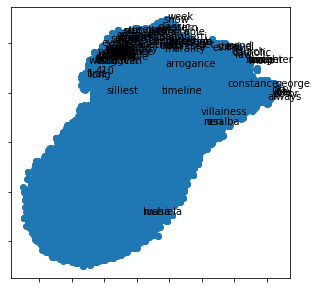

In [175]:
from sklearn.manifold import TSNE
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)[:100]):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [176]:
#単語のベクトル空間上の距離
model.wv.most_similar(positive="look", topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sound', 0.544180154800415),
 ('seem', 0.5268332362174988),
 ('stupidfunny', 0.496491402387619)]

## 【問題8】（アドバンス課題）Word2Vecを用いた映画レビューの分類
問題6で学習して得たベクトルや公開されている学習済みベクトルを用いてIMDB映画レビューデータセットの感情分類の学習・推定を行なってください。
